In [119]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

import torch.nn as nn
import torch.nn.functional as F

import math
import time

import skrf
from skrf import Network

import utils

In [120]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Grab some data

In [121]:
ROOT_PATH = "/scratch1/04703/sravula/UTAFSDataNew/new_data"
CHIP_NUM = 9

In [122]:
test_net = utils.get_network_from_file(ROOT_PATH, CHIP_NUM)['network']

In [123]:
print("S-parameters shape: ", test_net.s.shape)
print("S-parameters type: ", test_net.s.dtype)

S-parameters shape:  (1000, 4, 4)
S-parameters type:  complex128


In [124]:
N_PORTS = test_net.nports
N_FREQS = test_net.frequency.npoints

print("N_FREQS: ", N_FREQS)
print("N_PORTS: ", N_PORTS)

N_FREQS:  1000
N_PORTS:  4


In [125]:
reciprocity = skrf.network.reciprocity(test_net.s)

EPS_SMALL = 1e-6

IS_RECIPROCAL = False
if np.sum(np.abs(reciprocity)) < EPS_SMALL:
    IS_RECIPROCAL = True
    
print("RECIPROCAL: ", IS_RECIPROCAL)

RECIPROCAL:  True


# Grab a toch tensor from this guy

In [126]:
x_test = utils.network_to_sparams(test_net)

In [127]:
print(x_test.shape)
print(x_test.dtype)

torch.Size([1, 20, 1000])
torch.float32


# Grab the measurements that we will use as our ground truth

In [128]:
MEASUREMENT_SPACING = "equal"
M_GT = 0.1 #The ratio of measurements in our gold standard

KEPT_INDS_GT, MISSING_INDS_GT = utils.get_inds(MEASUREMENT_SPACING, N_FREQS, M_GT)

M_GT = len(KEPT_INDS_GT)

print("Number of Ground Truth Frequency Points: ", N_FREQS)
print("Number of Measurements: ", M_GT)
print("Undersampling Ratio: ", M_GT/N_FREQS)

Number of Ground Truth Frequency Points:  1000
Number of Measurements:  100
Undersampling Ratio:  0.1


In [129]:
y_test = torch.clone(x_test)[:, :, KEPT_INDS_GT]

print("y_test shape: ", y_test.shape)

y_test shape:  torch.Size([1, 20, 100])


In [130]:
z_test = torch.clone(x_test)
z_test[:, :, MISSING_INDS_GT] = 0

print("z_test shape: ", z_test.shape)

z_test shape:  torch.Size([1, 20, 1000])


# Plot the Data and measurements 

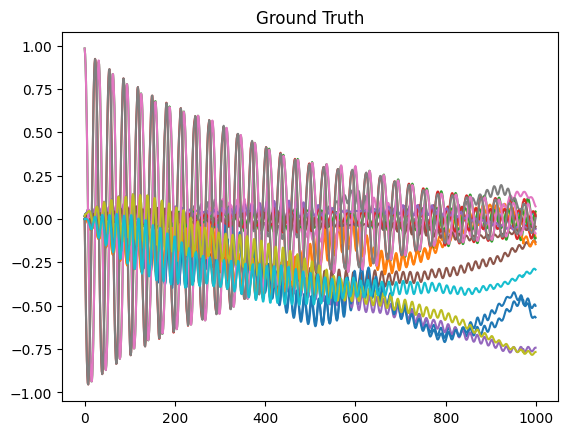

In [131]:
plt.figure()
for i in range(x_test.shape[1]//2):
    plt.plot(x_test[0, 2*i], label=str(i)+" Re")
    plt.plot(x_test[0, 2*i+1], label=str(i)+" Im")
plt.title("Ground Truth")
plt.show()

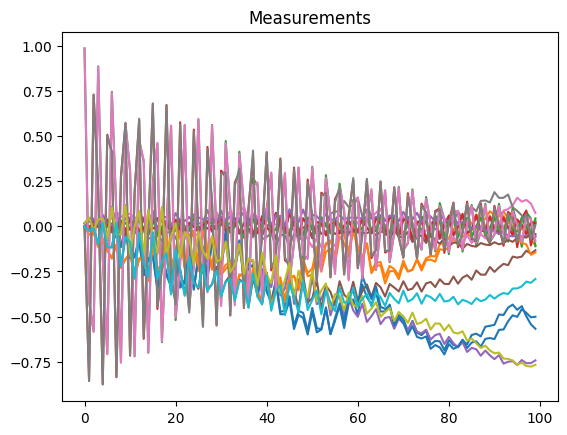

In [132]:
plt.figure()
for i in range(y_test.shape[1]//2):
    plt.plot(y_test[0, 2*i], label=str(i)+" Re")
    plt.plot(y_test[0, 2*i+1], label=str(i)+" Im")
plt.title("Measurements")
plt.show()

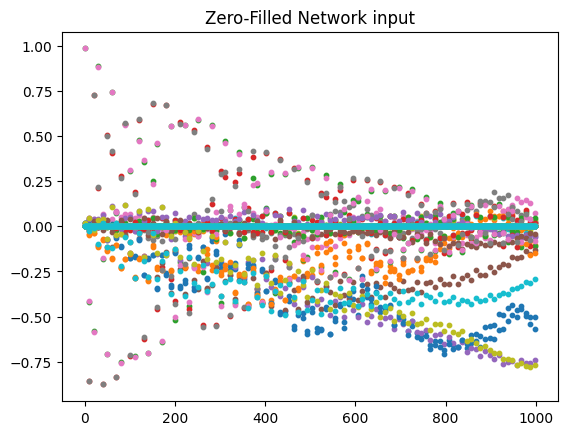

In [133]:
plt.figure()
for i in range(z_test.shape[1]//2):
    plt.scatter(np.arange(z_test.shape[-1]), z_test[0, 2*i], label=str(i)+" Re", s=10)
    plt.scatter(np.arange(z_test.shape[-1]), z_test[0, 2*i+1], label=str(i)+" Im", s=10)
plt.title("Zero-Filled Network input")
plt.show()

# Decide the Pre-Training Parameters

In [134]:
NUM_SCALES = 5
FATHER_SCALES = [1/i for i in range(1, NUM_SCALES+1)][::-1]

print("FATHER_SCALES: ", FATHER_SCALES)

FATHER_SCALES:  [0.2, 0.25, 0.3333333333333333, 0.5, 1.0]


In [135]:
FATHER_SAMPLES = []

for M in FATHER_SCALES:
    if M == 1.0:
        FATHER_SAMPLES.append(y_test)
    else:    
        KEPT_INDS, _ = utils.get_inds(MEASUREMENT_SPACING, M_GT, M)
        FATHER_SAMPLES.append(torch.clone(y_test)[:, :, KEPT_INDS])

torch.Size([1, 20, 20])


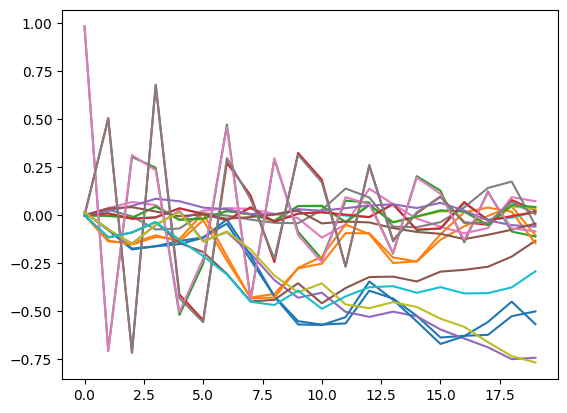

torch.Size([1, 20, 25])


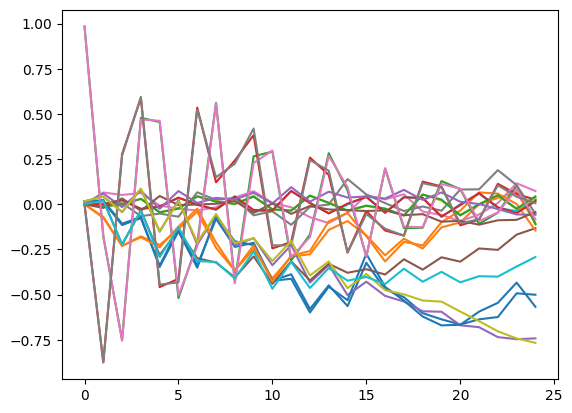

torch.Size([1, 20, 33])


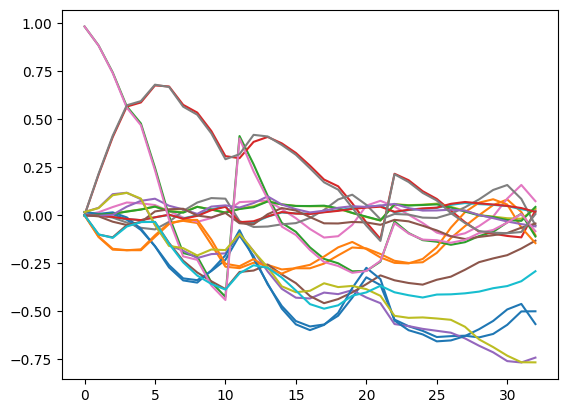

torch.Size([1, 20, 50])


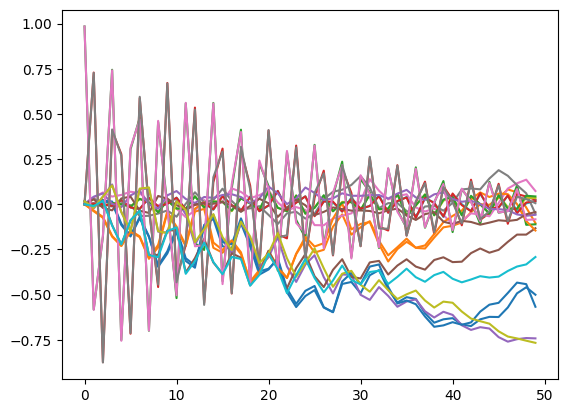

torch.Size([1, 20, 100])


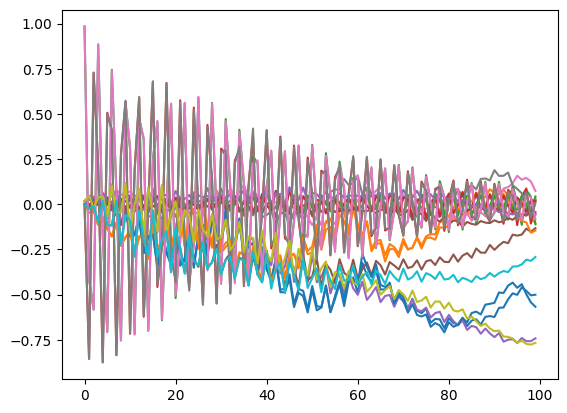

In [136]:
for FATHER in FATHER_SAMPLES:
    print(FATHER.shape)
    
    plt.figure()
    for i in range(FATHER.shape[1]//2):
        plt.plot(FATHER[0, 2*i], label=str(i)+" Re")
        plt.plot(FATHER[0, 2*i+1], label=str(i)+" Im")
    plt.show()

# Define the Augmentations

In [137]:
class Permute_Channels(object):
    """
    Augmentation that takes in a [2*Sparam, N_FREQ] array and returns a version with the S-parameters
        permuted randomly, making sure that pairs of adjacent real/imaginary channels stay together.
    """
    def __init__(self):
        pass
    
    def __call__(self, x):
        n_params = x.shape[-2] // 2 #number of s-parameters
        
        permuted_params = np.random.permutation(n_params) #randomly shuffled list [0...n_params]
        permuted_params = np.repeat(permuted_params, (2)) #repeat each permuted index e.g. [0,2,1]->[0,0,2,2,1,1]
        permuted_params[::2] = permuted_params[::2]*2 #double the even indices
        permuted_params[1::2] = permuted_params[1::2]*2 + 1 #double and offset the odd indices
        
        return x[:, permuted_params, :] #return a copy of the input with its channels permuted in pairs of re/im

In [138]:
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

class FatherDataset(Dataset):
    def __init__(self, father_samples, noise_sigma=0.01, measurement_spacing="equal", transform=None):
        self.father_samples = [father.clone() for father in father_samples]
        self.noise_sigma = noise_sigma
        self.measurement_spacing = measurement_spacing
        self.transform = transform
    
    def __len__(self):
        return len(self.father_samples)
    
    def __getitem__(self, idx):
        #(1) grab the proper tensor
        x = self.father_samples[idx]
        if self.transform:
            x = self.transform(x)
        
        len_x = x.shape[-1]
        
        #(2) grab the appropriate measurements from the father
        m = random.uniform(2/len_x, 0.5) #randomly sample the undersampling factor, with min 2 and max 50% samples
        kept_inds, missing_inds = utils.get_inds(self.measurement_spacing, len_x, m)

        z = torch.clone(x)
        z[:, :, missing_inds] = 0
        if self.noise_sigma:
            z = z + self.noise_sigma*torch.randn_like(z)
        
        return x, z

# Test a weighted selection of fathers

In [139]:
selection_prob = [np.exp(-1/i) for i in FATHER_SCALES]
sampler = WeightedRandomSampler(selection_prob, 1000, replacement=True)

print(selection_prob)

[0.006737946999085467, 0.01831563888873418, 0.049787068367863944, 0.1353352832366127, 0.36787944117144233]


In [140]:
transform = Permute_Channels()

dataset = FatherDataset(FATHER_SAMPLES, transform = transform)

dataloader = DataLoader(dataset, batch_size=1, sampler=sampler)

In [141]:
lens = {}

for x, _ in dataloader:
    len_x = x.shape[-1]
    if len_x in list(lens.keys()):
        lens[len_x] += 1
    else:
        lens[len_x] = 1

In [142]:
keys = sorted(lens.keys())
for k in keys:
    print(str(k) + ": " + str(lens[k]))

20: 16
25: 33
33: 80
50: 239
100: 632


In [ ]:
# Make the network